# A/B Testing - Bootstrap Hypothesis Testing

As opposed to $t$-test's a comparison of two samples via bootstrapping __doesn't require any assumptions__ such as normally distributed data. The bootstrap allows you to __work directly with the test statistic of interest__ (e.g. means instead of $t$ statistics) while making abstract concepts like sampling distributions, confidence intervals or Central Limit Theorem concrete. It's also not limited to the comparison of means.

In an A/B test we typically compare two or more samples - test and control groups - with each other which we consider to represent the general population of users. The __idea behind bootstrapping__ is to again randomly draw samples from each of the groups - not to get a better estimate of the population, but to get an estimate of how accurate our measurements are. Another important point to remember is that the bootstrap does not create something out of nothing, it rather __reflects the original samples__. The bootstrap distribution will always be centered at a given statistic of your sample (e.g. mean). Thus, if test and control groups are narrower/wider than the population the resulting bootstrap distribution will be narrower/wider than the population. It also __doesn't solve the problem of small sample sizes__ for making valid inference and especially when sample sizes are small ($n \le$ 34) bootstrapping can lead to inaccurate results.

## Prepare Data

In [36]:
# Read in sample data
data_control <- read.csv2("data/test_data_control.csv")$x
data_test <- read.csv2("data/test_data_test.csv")$x

In [37]:
# Compare means and standard deviations
print(paste("Control group sample size:", length(data_control),
            "& mean:", round(mean(data_control), 5),
            "& SD:", round(sd(data_control), 5)))
print(paste("Test group sample size:", length(data_test),
            "& mean:", round(mean(data_test), 5),
            "& SD:", round(sd(data_test), 5)))

[1] "Control group sample size: 1322095 & mean: 0.69085 & SD: 2.37184"
[1] "Test group sample size: 1322111 & mean: 0.69797 & SD: 2.41535"


In [ ]:
# Check for outliers ...
print(quantile(data_control, probs=c(0.9, 0.99, 0.999, 0.9999)))
print(quantile(data_test, probs=c(0.9, 0.99, 0.999, 0.9999)))

# ... and remove if considered to be necessary
#data_control <- data_control[data_control <= quantile(data_control, probs=0.9999)]
#data_test <- data_test[data_test <= quantile(data_test, probs=0.9999)]

## Test Statistic
Even though we use sample means for a comparison of test and control groups most of the time we could also use __any other test statistic of interest__. What's really nice about the bootstrap is that we don't need to learn how to conduct another test if we wanted to compare other statistics but means. Instead we apply the same methodology that we are already familiar with.

In [38]:
# Test statistic for comparison (e.g. mean or variance)
diff.vars  <- function(x,y) var(x) - var(y)
diff.means <- function(x,y) mean(x) - mean(y)

# H0: There is no difference between test & control groups
h0 <- 0
h0

# Observed difference between groups  (e.g. mean or variance)
obs.diff <- diff.vars(data_test, data_control)
obs.diff <- diff.means(data_test, data_control)
obs.diff

[1] 0

[1] 0.007121903

## Bootstrap Test
The process for comparing two independent samples of an A/B test via bootstrapping can be outlined as follows (for implementation details see function below):
1. __Repeat__ $r \ge$ 10000 times:
    - __Draw random samples__ of size n with replacement from estimates of the population represented by test and control group
    - __Compute the test statistic__ of interest e.g. the difference in means
2. __Make inference__ on the resulting bootstrap distribution i.e. the distribution of the test statistics e.g. calculate confidence intervals of distribution and reject $H0$ if it fails to include value of test statistic you are testing for (e.g. $H0$: There is no difference between test & control groups)

To answer to the question on __how many samples should be drawn__ is answered by the literature with $r \ge$ 10000 resamples for routine use and $r \ge$ 15000 resamples when greater accuracy matters. In fact using more bootstrap samples typically don't change center, spread and/or shape of the distribution, but only reduce variability.

In [7]:
# Bootstrapping test function
bootstrap.test <- function(x, y, test.statistic, resamples=1000) {
    # Runs two sample bootstrapping test for test statistic of interest
    #
    # Args:
    # - x: Vector with data for either test or control group
    # - y: Vector with data for either test or control group
    # - test.statistic: A function which compares groups
    # - resamples: Number of bootstrap samples to draw (defaults to 1000)
    #
    # Returns:
    # Distribution of test statistic
    
    # Size of original samples
    size.x  <- length(x)
    size.y <- length(y)
  
    # Bootstrapping function
    bootstrap.samples <- function() {
        # Sample from test & control with replacement
        boot.x  <- sample(x, size.x, replace = TRUE)
        boot.y <- sample(y, size.y, replace = TRUE)
    
        # Apply test statistis
        test.statistic(boot.x, boot.y)
    }
    # Draw n bootstrap samples of test & control with replacement (bootstrapping)
    # and compute test statistic
    replicate(resamples, bootstrap.samples())
}

## Confidence Intervals
A decision on accepting or rejecting the null hypothesis of our experiment is based on confidence intervals of the bootstrap distribution. In its most simple form these are based on __bootstrap percentiles intervals__ e.g. 2.5% and 97.5% percentiles for a 95% confidence interval. However, percentiles only work reasonably well when sample sizes are large ($n \ge$ 2400) and our data is not too skewed. Especially when working with small samples ($n \ge$ 101) one can use __bootstrap-$t$ confidence intervals__.

A test based on bootstrap-$t$ confidence intervals __estimates the actual distribution of a $t$ statistic__ by bootstrapping it and then uses the quantiles of the distribution in the confidence intervals. The bootstrapped $t$ statistic is defined as:

\begin{equation*}
\ t^* = \frac{\hat{\theta}^* - \theta}{\hat{S}^*}
\end{equation*}

with $\hat{\theta}$ being our estimate (e.g. difference in means $x_1-x_2$) and $\hat{S}$ being the standard error of the original sample and * denotes the parameters estimated from for \$i$th bootstrap sample.

Furthermore, let $q_α$ be the $\alpha$ quantile of the bootstrap-$t$ distribution, then the confidence interval is defined as:

$\ (\hat{\theta} - q_{1 - \alpha/2}\hat{S}, \hat{\theta} - q_{\alpha/2}\hat{S}) $

with the upper quantile of the bootstrap-$t$ distribution bein used for the lower endpoint, and vice versa.

The following function implements bootstrap-t confidence intervals. A __comparison of both__ bootstrap percentile and bootstrap-t intervals is shown in the last section below. Even though computationally more intense we recommend using __bootstrap-$t$ confidence intervals for accurate results__.

For more details on the theoretical background of confidence intervals for bootstrap test please refer to the [paper linked in the references](https://arxiv.org/pdf/1411.5279.pdf).

In [8]:
# Confidence intervals for bootstrap-t are defined as follows for 95% interval:
# Lower (0.025 = 0.05 / 2) = (observed difference in means - (bootstrap-t upper limit) * observed SE from original samples)
# Upper (0.975 = 1 - 0.05 / 2) = (observed difference in means - (bootstrap-t lower limit) * observed SE from orginal samples)

# Bootstrap-t confidence interval function
bootstrap.t <- function(x, y, test.statistic, alpha = 0.05, resamples = 1000) {
    # Estimates bootstrap-t confidence intervals for two sample bootstrap test
    # with test statistic of interest
    #
    # Args:
    # - x: Vector with data for either test or control group
    # - y: Vector with data for either test or control group
    # - test.statistic: A function which compares groups
    # - alpha: Accepted type I error rate (defaults to 0.05)
    # - resamples: Number of bootstrap samples to draw (defaults to 1000)
    #
    # Returns:
    # intervals: Bootstrap-t confidence intervals for statistic of interest
    
    # Define limits
    ci.lower <- alpha / 2
    ci.upper <- 1 - (alpha / 2)
    
    # Define paramters of original samples
    size.x <- length(x)
    size.y <- length(y)
  
    obs.diff <- test.statistic(x, y)
    se <- sqrt((var(x) / size.x) + (var(y) / size.y))
  
    # Bootstrap resampling function
    bootstrap.samples <- function() {
        # Draw n bootstrap samples of test & control with replacement (bootstrapping)
        boot.x  <- sample(x, size.x, replace = TRUE)
        boot.y <- sample(y, size.y, replace = TRUE)
        
        # Calculate t statistic of bootstrap samples
        (test.statistic(boot.x, boot.y) - obs.diff) / sqrt((var(boot.x) / length(boot.x)) + (var(boot.y) / length(boot.y)))
    }
    
    # Draw n bootstrap samples of test & control with replacement (bootstrapping)
    # and compute test statistic, the bootstrap t
    bootstrap.t <- replicate(resamples, bootstrap.samples())
  
    # Derive bootstrap-t confidence intervals
    intervals <- obs.diff - quantile(bootstrap.t, probs = c(ci.upper, ci.lower)) * se
    names(intervals) <- c(paste0(ci.lower * 100,"%"), paste0(ci.upper * 100, "%"))
    
    return(intervals)
}

## Results
Finally, we can do both run the boostrap test and estimate the corresponding confidence intervals before making final decision on rejecting/accepting $H0$. Then, we can plot a histrogram of our boostrap distribution (e.g. distribution of difference in means), add in confidence intervals and the value of our null hypothesis and make inference. If the __confidence interval fails to include the value representing our null hypothesis we will reject it__. Nonetheless, we can never be completely sure that the null hypothesis is false as we only make inference based on the data.

In [50]:
# Run bootstrapping test and compute bootstrap-t confidence intervals
# for given Type I error rate (alpha)
# This may take a while to run dependent on the number of resamples
alpha <- 0.05
bootstrap.results <- bootstrap.test(data_test, data_control, diff.means, 10000)
bootstrap.ci <- bootstrap.t(data_test, data_control, diff.means, alpha, 10000)

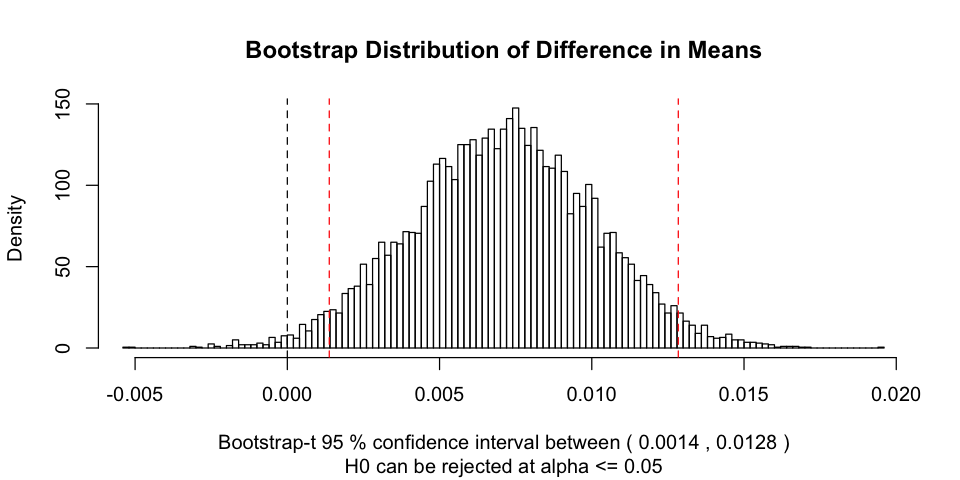

In [51]:
# Set plot size (specific to jupyter notebook)
require(repr)
options(repr.plot.width=8, repr.plot.height=4)

# Plot results
hist(bootstrap.results,
     breaks = 100,
     prob = T,
     main = "Bootstrap Distribution of Difference in Means",
     xlim = c(min(bootstrap.results, obs.diff), max(bootstrap.results, obs.diff)), 
     sub = ifelse(
         # Reject H0 if confidence interval fails to include H0
         h0 >= bootstrap.ci[1] & h0 <= bootstrap.ci[2], 
         paste0("H0 can not be rejected at alpha <= ", alpha), 
         paste0("H0 can be rejected at alpha <= ", alpha)),
     xlab = paste(
         "Bootstrap-t", (1-alpha)*100, "% confidence interval between (",
         round(bootstrap.ci[1], 4), ",", round(bootstrap.ci[2], 4), ")"))

# Add H0 and confidence interval limits
abline(v = h0, lty = 2, col = "black") # H0: There is no difference between groups
abline(v = bootstrap.ci[1], lty = 2, col = "red") # CI limit (lower)
abline(v = bootstrap.ci[2], lty = 2, col = "red") # CI limit (upper)

## Comparison
The following cell is meant to give an idea on how hypothesis testing based on bootstrapping compares to a standard $t$-test. Also, it's meant to compare both type of bootstrap confidence interval namely percentile intervals and bootstrap-$t$. Especially with sample sizes as large as the sample data used in this notebook each of the tests comes to the same result of rejecting $H0$.

In [52]:
# Compare bootstrap-t confidence intervals to bootstrap percentile intervals
# and t-test confidence intervals
paste("Bootstrap-t", (1-alpha)*100, "% confidence interval between (",
      round(bootstrap.ci[1], 4), ",", round(bootstrap.ci[2], 4), ")")
paste("Bootstrap percentile", (1-alpha)*100, "% confidence interval between (",
      round(quantile(x = bootstrap.results, probs = c(.025)), 4), ",", round(quantile(x = bootstrap.results, probs = c(.975)), 4), ")")
paste("T-test 95% confidence interval between (",
      round(t.test(data_test, data_control)$conf.int[1], 4), ",", round(t.test(data_test, data_control)$conf.int[2], 4), ")")

[1] "Bootstrap-t 95 % confidence interval between ( 0.0014 , 0.0128 )"

[1] "Bootstrap percentile 95 % confidence interval between ( 0.0013 , 0.0128 )"

[1] "T-test 95% confidence interval between ( 0.0014 , 0.0129 )"

## References
- [What Teachers Should Know about the Bootstrap](https://arxiv.org/pdf/1411.5279.pdf)